# **A2 ML - Laplace Redux**

### Implementing Laplace Approximation with `laplace` library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from laplace import Laplace
from sklearn.metrics import accuracy_score

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


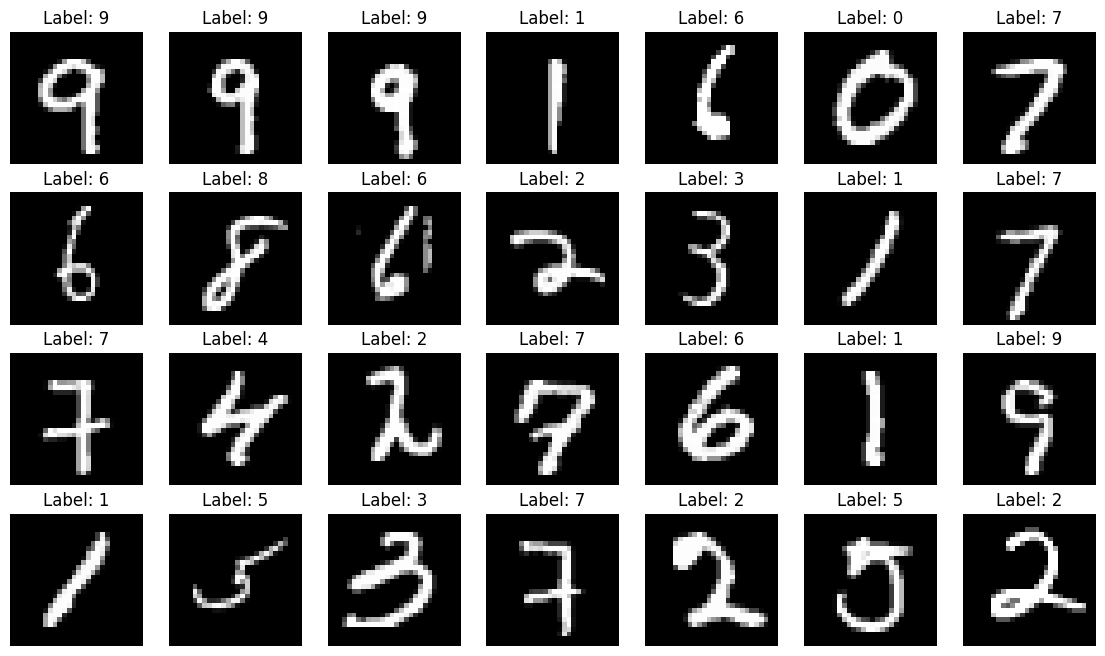

In [23]:
# View some images
images, labels = next(iter(train_loader))
plt.figure(figsize=(14, 8))
for i in range(28):
    plt.subplot(4, 7, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [3]:
# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


In [4]:
# Initialize the model, loss function and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer)


Epoch 1/5, Loss: 0.09159999340772629
Epoch 2/5, Loss: 0.3435804843902588
Epoch 3/5, Loss: 0.16265378892421722
Epoch 4/5, Loss: 0.2147330939769745
Epoch 5/5, Loss: 0.0063716755248606205


In [5]:
# Wrap the trained model with Laplace
la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='diag')

# Use the training data to fit the Laplace approximation
la.fit(train_loader)

In [6]:
# Function to evaluate the Laplace-approximated model
def evaluate_laplace(la, test_loader):
    la.model.eval()  # Put the original model in evaluation mode
    all_preds = []
    all_targets = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = la(data)  # Use the Laplace object for prediction
            _, predicted = torch.max(output, 1)
            all_preds.append(predicted.cpu())
            all_targets.append(target.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    accuracy = accuracy_score(all_targets, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Load test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Evaluate the Laplace-approximated model
evaluate_laplace(la, test_loader)


Accuracy: 96.57%


In [7]:
def predict_with_uncertainty(la, data_loader, n_samples=100):
    la.model.eval()
    all_mean_preds = []
    all_var_preds = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            samples = la.predictive_samples(data, n_samples=n_samples)
            mean_preds = samples.mean(0)
            var_preds = samples.var(0)
            all_mean_preds.append(mean_preds.cpu())
            all_var_preds.append(var_preds.cpu())

    mean_preds = torch.cat(all_mean_preds)
    var_preds = torch.cat(all_var_preds)
    return mean_preds, var_preds


In [31]:
# Get predictions with uncertainty
mean_preds, var_preds = predict_with_uncertainty(la, test_loader)


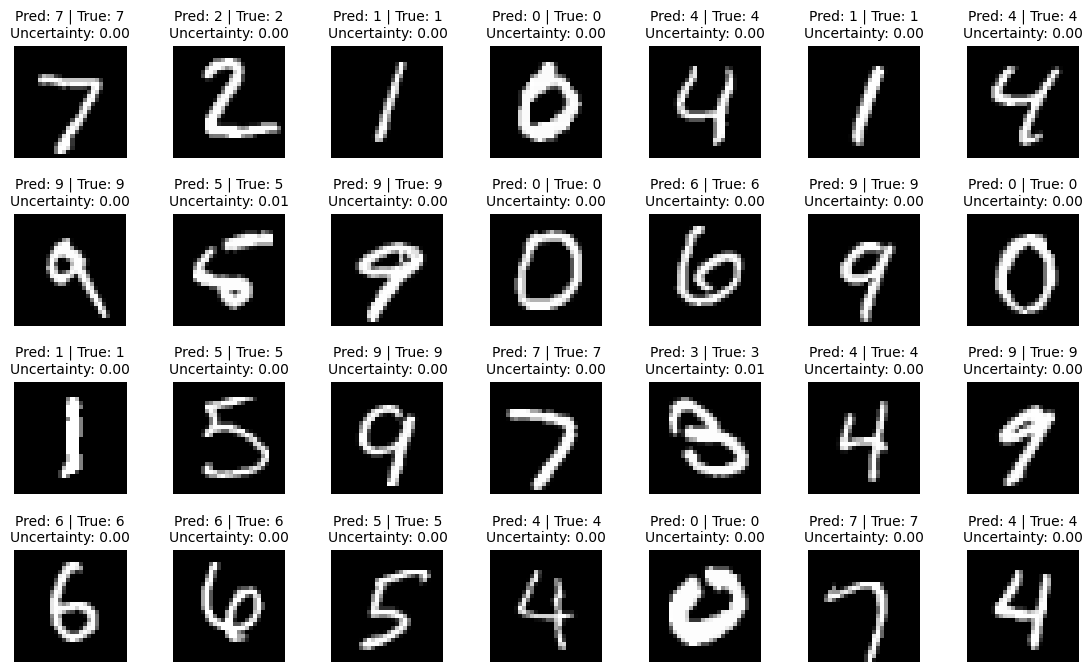

In [32]:
# Display some predictions with uncertainty
plt.figure(figsize=(14, 8))
for i in range(28):
    plt.subplot(4, 7, i+1)
    plt.imshow(test_dataset[i][0].squeeze(), cmap='gray')
    plt.title(f'Pred: {mean_preds[i].argmax().item()} | True: {test_dataset[i][1]}\nUncertainty: {var_preds[i].max().item():.2f}')
    plt.axis('off')
    plt.gca().title.set_fontsize(10)
    plt.subplots_adjust(hspace=0.5)
plt.show()

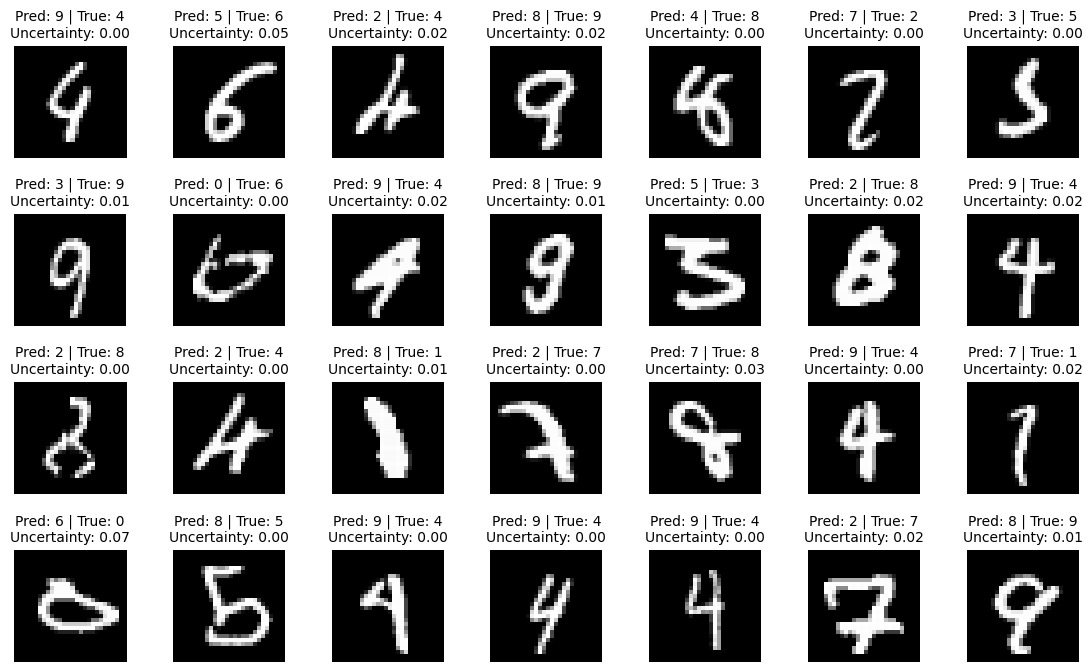

In [33]:
# Plot some incorrect predictions
incorrect = mean_preds.argmax(1) != test_dataset.targets
incorrect_images = test_dataset.data[incorrect]
incorrect_preds = mean_preds[incorrect]
incorrect_vars = var_preds[incorrect]

plt.figure(figsize=(14, 8))
for i in range(28):
    plt.subplot(4, 7, i+1)
    plt.imshow(incorrect_images[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {incorrect_preds[i].argmax().item()} | True: {test_dataset.targets[incorrect][i]}\nUncertainty: {incorrect_vars[i].max().item():.2f}')
    plt.axis('off')
    plt.gca().title.set_fontsize(10)
    plt.subplots_adjust(hspace=0.5)
plt.show()